In [81]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pylab
%matplotlib inline
from scipy.integrate import odeint

In [82]:
#with pylab inline, make bigger images
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [83]:
"""
Paper specifics
Sampling Period = 10ms
Simulation Period = 2s
N = 200 (samples)
For NSGA:
  Search ranges:
    Kp1,Kp2 : [0:350]
    Kv1,Kv2,Ki1,Ki2 : [0:50]

  Population Size : 40
  Stopping Criterion : 200 generations

Manipulator:
  m1 = m2 = 0.1kg
  l1 = 0.8m 
  l2 = 0.4m
  g = 9.81 m/s2
  torque constraint = [-1000,1000]
"""

'\nPaper specifics\nSampling Period = 10ms\nSimulation Period = 2s\nN = 200 (samples)\nFor NSGA:\n  Search ranges:\n    Kp1,Kp2 : [0:350]\n    Kv1,Kv2,Ki1,Ki2 : [0:50]\n\n  Population Size : 40\n  Stopping Criterion : 200 generations\n\nManipulator:\n  m1 = m2 = 0.1kg\n  l1 = 0.8m \n  l2 = 0.4m\n  g = 9.81 m/s2\n  torque constraint = [-1000,1000]\n'

# **Trajectory equations**

In [84]:
"""
Utility funtions for theta_desired equations
"""

def solve_equation(A,B):
  """
  Solves the equation of form AX = B
  """
  return np.linalg.inv(A).dot(B)

def get_time_interval():
  """
  returns a list of discrete time values between a time interval
  """
  x=0
  time_interval = []
  while True:
   time_interval.append(x/200)
   x+=4
   if x==800:
    break
  time_interval.append(4)
  return time_interval

def get_theta_desired1(num):
  """
  Equation identical to the one given in paper.
  """
  value = 0.125*num**3 - 1.125*num**2 + 3*num - 1.5
  return value

def get_theta_desired2(num):
  """
  Equation identical to the one given in paper.
  """
  value = -0.5*num**3 + 4.5*num**2 - 12*num + 12
  return value

def get_theta_desired1_alt(num):
  """
  Equation interpolated in 4-degree to get a better curve.
  """
  value = 0.0234375*(num**4) - 0.15625*(num**3) + 0.09375*(num**2) + 0.75*num
  return value

def get_theta_desired2_alt(num):
  """
  Equation interpolated in 4-degree to get a better curve.
  """
  value = -0.1875*(num**4) + 1.75*(num**3) - 5.25*(num**2) + 6*num
  return value

def get_theta_dot_des1(num):

  value = 0.09375*(num**3) - 0.46875*(num**2) + 0.1875*(num) + 0.75
  return value

def get_theta_dot_des2(num):

  value = -0.75*(num**3) + 5.25*(num**2) - 10.5*(num) + 6
  return value

def get_theta_desired(time_interval,verbose = 'modified'):

  theta_des1 = []
  theta_des2 = []
  theta_dot_des1 = []
  theta_dot_des2 = []
  for t in time_interval:
    if verbose == 'original':
      theta_des1.append(get_theta_desired1(t))
      theta_des2.append(get_theta_desired2(t))
    else:
      theta_des1.append(get_theta_desired1_alt(t))
      theta_des2.append(get_theta_desired2_alt(t))
      theta_dot_des1.append(get_theta_dot_des1(t))
      theta_dot_des2.append(get_theta_dot_des2(t))

  return theta_des1, theta_des2, theta_dot_des1, theta_dot_des2


In [85]:
A = np.array([[1, 2, 4, 8], [1, 4, 16, 64], [0, 1, 4, 12],[0, 1, 8, 48]])
B = np.array([1, 0.5, 0, 0])
X = solve_equation(A,B)

print(X)

[-1.5    3.    -1.125  0.125]


In [86]:
#get desired theta values
time_interval = get_time_interval()
theta_des1, theta_des2, theta_dot_des1, theta_dot_des2 = get_theta_desired(time_interval)

No handles with labels found to put in legend.


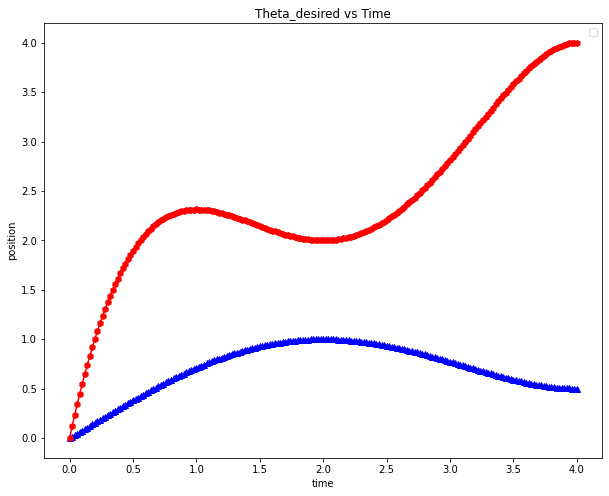

In [87]:
#plot desired trajectory
plt.plot(time_interval, theta_des1, "b-^", )
plt.plot(time_interval, theta_des2, "r-h", )
plt.legend()
plt.title('Theta_desired vs Time')
plt.ylabel('position')
plt.xlabel('time')
plt.show()

# PID

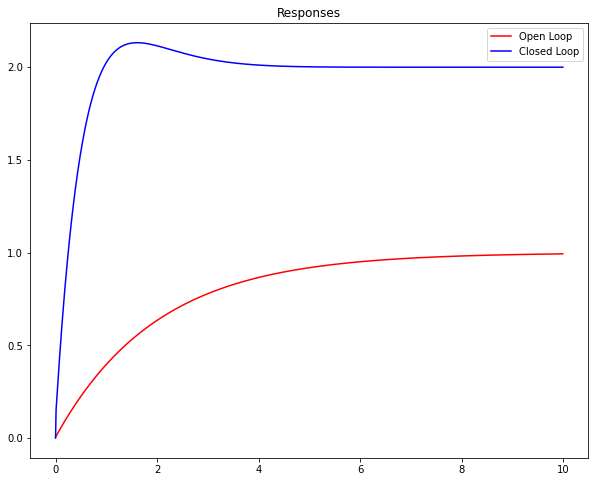

In [88]:
# Initialization

Fs = 100 # Sampling Frequency
Tf = 10 # Final Time
Ti = 0 # Initial Time
Ts = 1 / Fs

# Number of samples
n_samples = math.floor(Tf / Ts) 
t = np.arange(Ti,Tf,Ts)

# Parameters
tau = 2
Kp = 5
Ki = 5
Kd = 0.1

# Step response
m = np.ones(n_samples+1)
m_cont = np.zeros(n_samples+1)

y_open_loop = np.zeros(n_samples+1)
y = np.zeros(n_samples+1)
y_sp = 2*np.ones(n_samples+1) # Reference


e = np.zeros(n_samples+1)
int_e = np.zeros(n_samples+1)
diff_e = np.zeros(n_samples+1)

for i in range(0,n_samples):
    y_open_loop[i+1] = (1 - (Ts/tau))*y_open_loop[i] + (Ts/tau)*m[i]
    y[i+1] = (1 - (Ts/tau))*y[i] + (Ts/tau)*m_cont[i]
    
    e[i+1] = y_sp[i+1] - y[i+1] # Calculation of Error
    int_e[i+1] = int_e[i] + Ts* e[i+1] # Calculation of Integral of Error
    diff_e[i+1] = (e[i+1] - e[i]) /Ts # Calculation of Derivative of Error
    m_cont[i+1] = Kp* e[i+1] + Ki * int_e[i+1] + Kd* diff_e[i+1] # Calculation of Controller Output
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t,y_open_loop[1:],'r-', label='Open Loop')
ax.plot(t,y[1:], 'b-', label='Closed Loop')
plt.title('Responses')
ax.legend()
plt.show()

In [113]:
def solve_joint1(U,t,T1):
  torque1 = T1
  return [U[1],0.2140*U[1] - 0.1730*U[0] + 0.00265*torque1]

def solve_joint2(U,t,T2):
  torque2 = T2
  return [U[1],-0.130321*U[1] - 0.00197844*U[0] + 0.00935089*torque2]

def plant(torque1,torque2,error,velocity,time_interval,time_instant):
  """
  Given the torque at an instant t, this functions returns theta and velocity at instant t+1. 
  
  (x1,x2,x3,x4) = (theta1 - theta_des1, theta_dot1 - theta_dot_des1,theta2 - theta_des2, theta_dot2 - theta_dot_des2)
  
  """
  U1 = [error[0][time_instant-1], velocity[0][time_instant-1]]
  U2 = [error[1][time_instant-1], velocity[1][time_instant-1]]
  t = np.linspace(time_interval[time_instant-1], time_interval[time_instant],2)
  out1 = odeint(solve_joint1, U1, t, args=(torque1,))
  out2 = odeint(solve_joint2, U2, t, args=(torque2,))
  # print("U1 : ", U1)
  # print("U2 : ", U2)
  # print("ode1 : ", out1)
  # print("ode2 : ", out1[:,0])
  error[0][time_instant] = out1[:,0][1]
  error[1][time_instant] = out2[:,0][1]
  return error[0][time_instant],error[1][time_instant]

def pid(solution,theta_des1,theta_des2,theta_dot_des1,theta_dot_des2,time_interval):
    """
    Inputs:
        solution : 2-D list containing values of PID params : [[Kp1 Kv1 Ki1] , [Kp2 Kv2 Ki2]]
        theta_des1, theta_des2 :  okalist of final theta values at a given time instant.
        theta_dot_des1, theta_dot_des2 : list of velocities at a given time instant 
    Outputs:
        Plant Dyanmics. (numpy array) Note that it is in discrete domain
                                      Length: floor((Tf- Ti)*Fs)
    """
    theta_des = np.vstack((theta_des1,theta_des2))
    theta_dot_des = np.vstack((theta_dot_des1,theta_dot_des2))
    Kp,Kv,Ki = [],[],[]
    for i in range(2):
      Kp.append(solution[i][0])
      Kv.append(solution[i][1])
      Ki.append(solution[i][2])
    
    Ts = 0.01 #10ms
    n = 200 # number of samples in the time interval 
    T = 1
    theta = np.zeros((2,n+1))
    error = np.zeros((2,n+1))
    velocity = np.zeros((2,n+1))
    torque = np.zeros((2,n+1))   
    error[0][0] = -1
    error[1][0] = -1

    for j in range(1,n):
      error[0][j],error[1][j] = plant(torque[0][j-1],torque[1][j-1],error,velocity,time_interval,j)

      for i in range(2):
        theta[i][j] = error[i][j]+theta_des[i][j]
        velocity[i][j] = (theta_des[i][j] - theta_des[i][j-1] - theta[i][j] + theta[i][j-1])/T
        torque[i][j] = (Kp[i] + 0.5*Ts*Ki[i])*error[i][j] - (Kp[i] - 0.5*Ts*Ki[i])*error[i][j-1] + (Kv[i])*(velocity[i][j] + velocity[i][j-1])
        # print("theta : ",theta[i][j],"velocity: ",velocity[i][j],"torque : ", torque[i][j] )

    return theta,torque,velocity

No handles with labels found to put in legend.


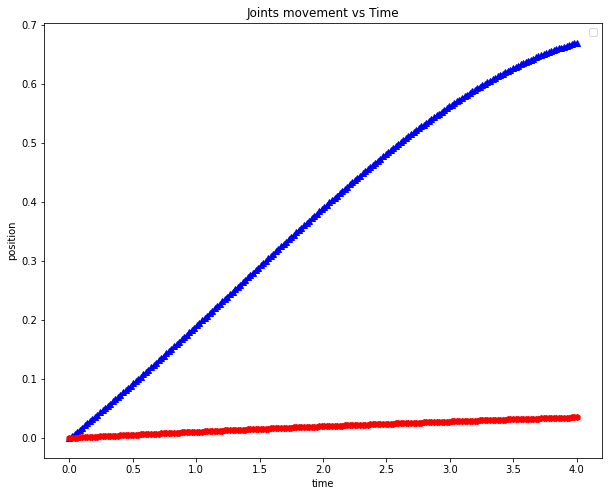

In [90]:
U1 = [-1, 0]
U2 = [-1, 0]
t = np.linspace(0,4,200)
out1 = odeint(solve_joint1, U1, t, args=(1,))
out2 = odeint(solve_joint2, U2, t,args=(1,))

plt.plot(t, out1[:,1], "b-^", )
plt.plot(t, out2[:,1], "r-h", )
plt.legend()
plt.title('Joints movement vs Time')
plt.ylabel('position')
plt.xlabel('time')
plt.show()

# **NSGA - II**

In [91]:
pop_size = 40
max_gen = 30
Kp_range = 350
Kvi_range = 50

In [92]:
def GenerateIndividual():
  """
  This generates a individual of the population with random values within the range
  output : 2d - List : [[Kp1 Kv1 Ki1] , [Kp2 Kv2 Ki2]]
  """
  individual = [[None for j in range(3)] for i in range(2)]

  for i in range(2):
    for j in range(3):
      if j == 0:
        individual[i][j] = random.uniform(0,Kp_range)
      else:  
        individual[i][j] = random.uniform(0,Kvi_range)

  return individual

def initPop(pop_size):
  """
  Input : population size
  Output : list of required number of individuals in the population
  """
  assert pop_size > 0

  population = []
  for p in range(pop_size):
    indiv = GenerateIndividual()
    population.append(indiv)
  
  return population

In [103]:
def get_fitness(solution,flag = True):

  theta,torque,veloctiy = pid(solution,theta_des1,theta_des2,theta_dot_des1,theta_dot_des2,time_interval)

  if flag:
    fitness = obj_fun1(theta[0],theta[1],theta_des1,theta_des2)
  else:
    fitness = obj_fun2(torque[0],torque[1])

  return fitness

def obj_fun1(theta1,theta2,theta_des1,theta_des2):
  """
  Returns the first fitness value
  """
  sum_theta1 = 0.0
  for i in range(1,len(theta1)):
    val = abs(theta1[i]-theta_des1[i])
    sum_theta1+=val

  sum_theta2 = 0.0
  for i in range(1,len(theta2)):
    val = abs(theta2[i]-theta_des2[i])
    sum_theta2+=val

  fitness1 = sum_theta1 + sum_theta2 

  return fitness1

def obj_fun2(tau1,tau2):
  """
  Returns the second fitness value
  """
  sum_tau1 = 0.0
  for i in range(1,len(tau1)):
    val = abs(tau1[i] - tau1[i-1])
    sum_tau1+=val

  sum_tau2 = 0.0
  for i in range(1,len(tau2)):
    val = abs(tau2[i] - tau2[i-1])
    sum_tau2+=val

  fitness2 = sum_tau1 + sum_tau2

  return fitness2


In [104]:
#check random individual
random.seed(111)
ind = GenerateIndividual()
ind

[[289.5096978698099, 10.638155758808631, 47.12597218005898],
 [172.87190085629442, 19.87935767209953, 30.858233873422826]]

In [105]:
def Non_dominated_sorting(f1_values,f2_values):
  """
  Non dominated sorting of population based on values of two objective fundtion
  Input : f1_values is the list of objective1 fitness score of each individual in the population
          f2_values is the list of objective1 fitness score of each individual in the population
  Note : Here the index of f1_values and f2_values correspond to the location of individual in original solution
  Output : Sorted indices of solution based on Non domination

  Note: We will be using the following parameters in the algo:
        Sp : 2D list that stores the set of solution this individual p is dominating.
        np : Number of solution that dominate this individual p. 
        rank : store the rank of each solution
        front: 2D list that store the solution belonging to each front

  """
  pop_size = len(f1_values)
  S = [[] for i in range(pop_size)]
  n = [0 for i in range(pop_size)]
  rank = [0 for i in range(pop_size)]
  fronts = [[]]

  #the code below gives the non dominated front
  for p in range(pop_size):
    for q in range(pop_size):
      if(p == q): 
        continue

      if((f1_values[p] > f1_values[q] and f2_values[p] > f2_values[q]) or (f1_values[p] >= f1_values[q] and f2_values[p] > f2_values[q]) or (f1_values[p] > f1_values[q] and f2_values[p] >= f2_values[q])):
        S[p].append(q)
      elif((f1_values[p] < f1_values[q] and f2_values[p] < f2_values[q]) or (f1_values[p] <= f1_values[q] and f2_values[p] < f2_values[q]) or (f1_values[p] < f1_values[q] and f2_values[p] <= f2_values[q])):
        n[p]+=1

    if n[p] == 0: # i.e. p in nondominated
      rank[p] = 0
      if p not in fronts[0]:
        fronts[0].append(p) #append to the first front

  #calculating the other fronts to meet population size requirements  
  ind = 0
  
  while len(fronts[ind]) != 0:
    queue = []
    for p in fronts[ind]:
      for q in S[p]:
        n[q]-=1
        if n[q] == 0:
          queue.append(q)
          rank[q] = ind+1
    ind+=1
    fronts.append(queue)
  
  del(fronts[len(fronts)-1]) #remove the empty list from the end
  return fronts

def get_sorted(front,values):
  """
  Input : 
      front : population
      values : value wrt which the population will be sorted
  Returns sorted front according to the fitness values.
  """
  sorted_front = []
  front_arr = np.array(front)
  val_arr = np.array(values)
  while len(sorted_front)!=len(front):
    if np.argmin(val_arr) in front_arr:
      sorted_front.append(np.argmin(val_arr))
    val_arr[np.argmin(val_arr)] = np.inf
  return sorted_front

def crowding_dist(front,f1_values,f2_values):
  """
  Calculates the crowding distance of each individual
  Input : front is the individuals belonging to a given front
          f1_values and f2_values are the respective firness value of each individual
  Ouput : list of crowding distances of each individual
  Note : crowding distance is how close the given solution is to its neighbouring solutions
          in the same front. We will select individuals with higher crowding distance for diversity.
  """
  n = len(front)
  distances = [0 for i in range(n)]
  distances[0] = np.inf
  distances[n-1] = np.inf

  sorted_f1 = get_sorted(front,f1_values) 
  sorted_f2 = get_sorted(front,f2_values)
  
  for i in range(1,n-1):
    if i == n-2:
      distances[i] = distances[i]+(f1_values[sorted_f1[i+1]] - f1_values[sorted_f1[i-1]])/(max(f1_values)-min(f1_values))
    else:  
      distances[i] = distances[i]+(f1_values[sorted_f1[i+1]] - f1_values[sorted_f1[i-1]])/(max(f1_values)-min(f1_values))

  for i in range(1,n-1):
    distances[i] = distances[i]+(f2_values[sorted_f2[i+1]] - f2_values[sorted_f2[i-1]])/(max(f2_values)-min(f2_values))

  return distances
 
   
def crossover(parent1,parent2):
  """
  Creates an offspring by randomly selecting genes from parents.
  Mutation is done to  further increase diversity.
  Input : Two random individuals from population
  Output : Offspring
  """
  threshold = 0.25
  
  if random.random() > 0.5:
    offspring = parent1
  else:
    offspring = parent2

  if random.random() > threshold:

    if random.random() > 0.5:
      offspring[0][0] = parent1[0][0]
      offspring[1][0] = parent2[1][0]

      for i in range(1,3):
        offspring[0][i] = parent1[0][i]
        offspring[1][i] = parent2[1][i]
    else:
      offspring[0][0] = parent2[0][0]
      offspring[1][0] = parent1[1][0]

      for i in range(1,3):
        offspring[0][i] = parent2[0][i]
        offspring[1][i] = parent1[1][i]

  offspring = mutation(offspring)
  
  return offspring

def mutation(indiv):
  """
  Each of the genes of an individual gets modified based on the probability threshold set.
  """
  threshold = 0.08 #probability that each gene gets mutated is 8%.

  for i in range(2):
    for j in range(3):
      if random.random() <= threshold:
        val = random.uniform(-1,1)
        indiv[i][j]+=val

  return indiv



In [114]:
"""
Main function to run NSGA-II optimistation on Robotic Arm
"""

solution = initPop(pop_size) #initialize the first population
max_gen = 1
gen = 0
while(gen < max_gen):
  f1_values = [get_fitness(solution[i],flag=True) for i in range(pop_size)]
  f2_values = [get_fitness(solution[i],flag=False) for i in range(pop_size)]

  #return a 2D list of fronts, front[0] is non dominated
  sorted_fronts = Non_dominated_sorting(f1_values,f2_values) 

  #calculate crowding distance values in each front
  crowding_dist_values = []
  for i in range(len(sorted_fronts)):
    crowding_dist_values.append(crowding_dist(sorted_fronts[i],f1_values,f2_values))
  
  solution2 = solution[:]

  #generate offspring and create an extended population with parents
  while(len(solution2)!=2*pop_size):
    a1 = np.random.randint(0,pop_size-1)
    b1 = np.random.randint(0,pop_size-1)
    #create an offspring by selecting two parents randomly
    solution2.append(crossover(solution[a1],solution[b1]))
  
  #calc fitness values for extended population
  f1_values2 = [get_fitness(solution2[i],flag = True) for i in range(pop_size)]
  f2_values2 = [get_fitness(solution2[i],flag = False ) for i in range(pop_size)]
  
  #non dominated sorted fronts for child population
  sorted_fronts2 = Non_dominated_sorting(f1_values2,f2_values2)
  
  #calculate crowding dist for second population
  crowding_dist_values2 = []

  for i in range(len(sorted_fronts2)):
    crowding_dist_values2.append(crowding_dist(sorted_fronts2[i],f1_values2,f2_values2))

  best_selected = [] #best P from population of 2P individuals
  for i in range(len(sorted_fronts2)):
    front_indexes = [j for j in range(len(sorted_fronts2[i]))]
    sorted_front_indexes = get_sorted(front_indexes,crowding_dist_values2[i])

    front = [sorted_fronts2[i][sorted_front_indexes[h]] for h in range(len(sorted_front_indexes))]
    #reverse the front since the indexes got sorted in ascending order
    #while we need the solutions with large crowding distance
    front.reverse()
    
    for val in front:
      if(len(best_selected) >= pop_size):
        break
      best_selected.append(val)
    
    if(len(best_selected) >= pop_size):
        break

  solution = [solution2[i] for i in best_selected]
  fitness1 = [get_fitness(solution[i],flag = True) for i in range(pop_size)]
  fitness2 = [get_fitness(solution[i],flag = False) for i in range(pop_size)]
  print(fitness1)
  print(fitness2)
  gen+=1





[394.0572150827156, 394.0572150827156, 394.07214354377993, 394.06390911246285, 394.0436110755387, 394.0369979246891, 394.05096248633095, 394.054770750712, 394.0675165499346, 394.0675165499346, 394.0428871083436, 394.04407143902347, 394.04498322802976, 394.05523330785775, 394.0470500107296, 394.0665998419962, 394.06343058363086, 394.05717004827113, 394.0367977844269, 394.03962125150815, 394.03962125150815, 394.0304068449411, 394.0541711880304, 394.0422193481438, 394.05337655958886, 394.06205481255256, 394.0403284205156, 394.03855622857924, 394.03855622857924, 394.0260455695883, 394.0597922572097, 394.0493166084126, 394.0374947046147, 394.0374947046147, 394.04762200154494, 394.0319224057379, 394.0348854095966, 394.0339827134496, 394.0339827134496, 394.04080582127176]
[120.57907059835057, 120.57907059835057, 45.53229929867515, 70.78297860381255, 166.22207913385924, 192.0685600435753, 148.46596812950997, 141.22395084008429, 22.171262175947, 22.171262175947, 156.86491814046673, 148.29113838

In [116]:
solution

[[[237.50644181564155, 45.8300674847994, 14.227645406067785],
  [341.80522344537985, 2.6441908186231933, 22.46987814014742]],
 [[237.50644181564155, 45.8300674847994, 14.227645406067785],
  [341.80522344537985, 2.6441908186231933, 22.46987814014742]],
 [[292.5734775715256, 9.033533270618483, 35.134350298518136],
  [213.13297497518244, 3.414521623270339, 37.29887069414279]],
 [[271.8277919410034, 16.48482993292692, 38.64083727301908],
  [178.69650650861072, 9.713648488637528, 29.04274206955672]],
 [[178.1465057178877, 40.19475886814302, 3.1177732518984036],
  [75.7440895263434, 37.734597948014816, 48.68853594815672]],
 [[248.2601906380389, 44.66454600847261, 33.73612113696355],
  [280.6117280341463, 40.583398180841414, 34.134308210654254]],
 [[129.12714462900524, 45.07381837046891, 43.9744239432044],
  [136.7058540128422, 23.740535576435807, 33.470586043171316]],
 [[151.53768424536358, 46.69856565509637, 34.18301261900494],
  [96.43547831249431, 18.856281542646098, 37.47887740391762]],


In [115]:
"""
Testing the best solution
"""
sol = [[157.13575295411923, 26.514295346340873, 49.107306373231424],
  [7.295850203634651, 23.90932819405398, 9.191620149891046]]
# sol = GenerateIndividual()
theta,torque,velocity = pid(sol,theta_des1,theta_des2,theta_dot_des1,theta_dot_des2,time_interval)

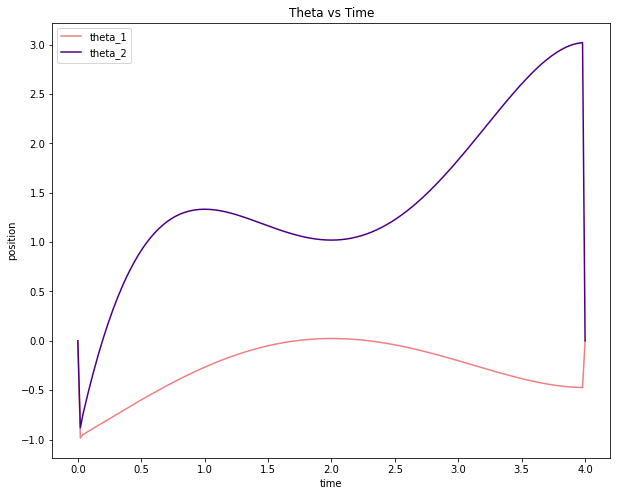

In [119]:
plt.plot(time_interval, theta[0], color='lightcoral' ,label='theta_1' )
plt.plot(time_interval, theta[1], color='#4b0082' ,label='theta_2')
plt.legend()
plt.title('Theta vs Time')
plt.ylabel('position')
plt.xlabel('time')
plt.show()

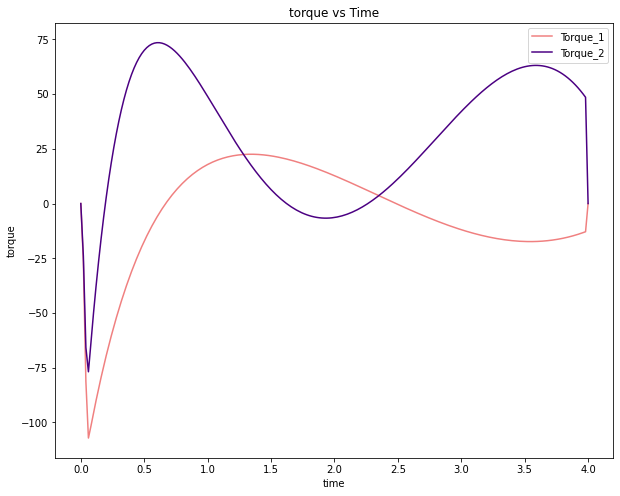

In [101]:
plt.plot(time_interval, -torque[0], color='lightcoral' ,label='Torque_1' )
plt.plot(time_interval, -torque[1], color='#4b0082' ,label='Torque_2')
plt.legend()
plt.title('torque vs Time')
plt.ylabel('torque')
plt.xlabel('time')
plt.show()